In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np

In [4]:
measure_csv = pd.read_csv('./encoder.csv')

In [5]:
print(measure_csv)

            time     gFx     gFy     gFz    TgF
0       0.004857  0.0221  0.9713  0.2244  0.997
1       0.005302  0.0225  0.9728  0.2224  0.998
2       0.005582  0.0246  0.9794  0.2235  1.005
3       0.005862  0.0205  0.9759  0.2263  1.002
4       0.006090  0.0217  0.9740  0.2279  1.001
...          ...     ...     ...     ...    ...
19979  49.291203  0.0375  0.9929  0.2179  1.017
19980  49.292519  0.0356  0.9894  0.2166  1.013
19981  49.293187  0.0124  0.9736  0.1993  0.994
19982  49.297603  0.0036  0.9764  0.2044  0.998
19983  49.298314  0.0276  0.9771  0.2161  1.001

[19984 rows x 5 columns]


In [31]:
measure_csv = measure_csv[(measure_csv['time'] > 12) & (measure_csv['time'] < 20)]


times = measure_csv['time']
X_axis = measure_csv['gFx']
Y_axis = measure_csv['gFy']
Z_axis = measure_csv['gFz']

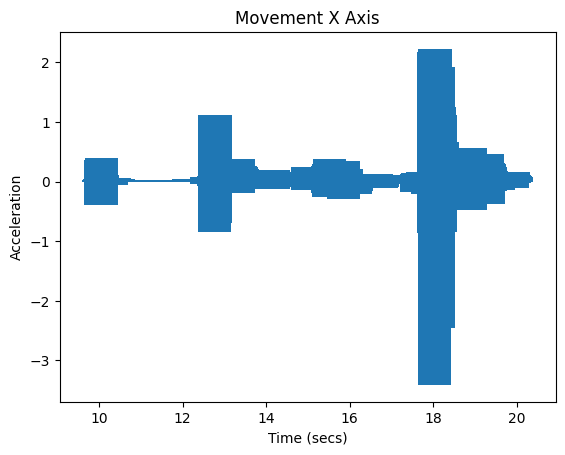

In [25]:
plt.bar(times, X_axis)
plt.xlabel('Time (secs)')
plt.ylabel('Acceleration')
plt.title('Movement X Axis')

# Mostrar el gráfico
plt.show()

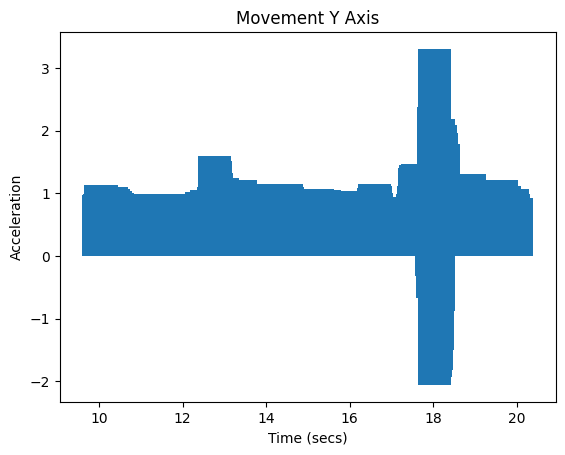

In [26]:
plt.bar(times, Y_axis)
plt.xlabel('Time (secs)')
plt.ylabel('Acceleration')
plt.title('Movement Y Axis')

# Mostrar el gráfico
plt.show()

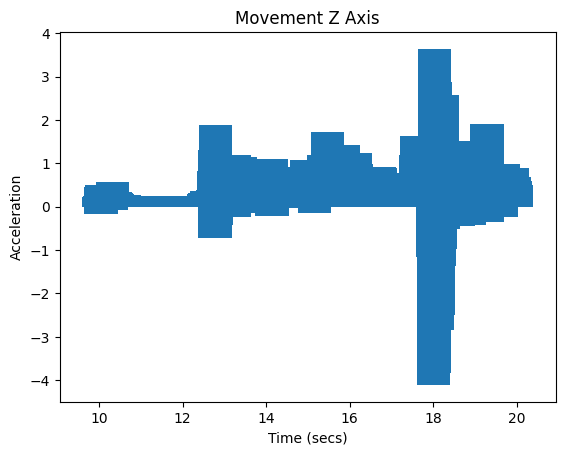

In [27]:
plt.bar(times, Z_axis)
plt.xlabel('Time (secs)')
plt.ylabel('Acceleration')
plt.title('Movement Z Axis')

# Mostrar el gráfico
plt.show()

## FILTER Y SIGNAL

In [32]:
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

fs = 100  # Frecuencia de muestreo (ejemplo: 100 Hz)
cutoff = 5  # Frecuencia de corte del filtro
acc_Y_filtered = butter_lowpass_filter(Y_axis, cutoff, fs)


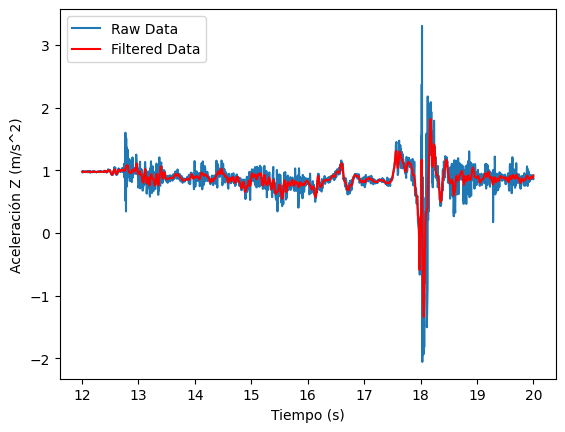

In [33]:
plt.plot(times, Y_axis, label='Raw Data')
plt.plot(times, acc_Y_filtered, label='Filtered Data', color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración Z (m/s^2)')
plt.legend()
plt.show()


KeyError: "None of [Index([3240, 3275], dtype='int64')] are in the [index]"

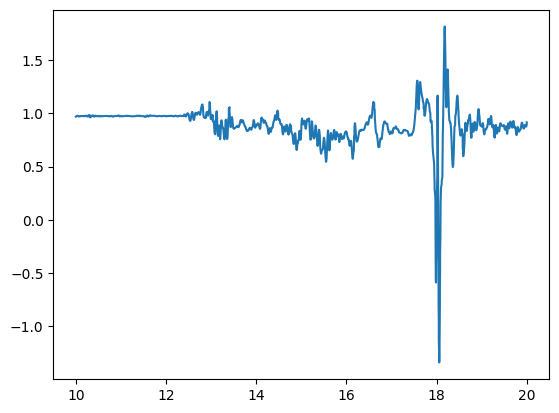

In [30]:
# Detectar los índices donde ocurre el cambio de signo en la aceleración (de negativo a positivo o viceversa)
ascenso = np.where(np.diff(np.sign(acc_Y_filtered)) > 0)[0]  # Cambio de negativo a positivo (inicio del ascenso)
descenso = np.where(np.diff(np.sign(acc_Y_filtered)) < 0)[0]  # Cambio de positivo a negativo (inicio del descenso)

# Opcional: Detectar pausas cuando la aceleración está cerca de cero
pausa = np.where(np.abs(acc_Y_filtered) < 0.05)[0]  # Define umbral de aceleración cercana a cero

# Visualización de las fases
plt.plot(times, acc_Y_filtered, label='Filtered Aceleration Z')
plt.scatter(times[ascenso], acc_Y_filtered[ascenso], color='green', label='Inicio de Ascenso', marker='^')
plt.scatter(times[descenso], acc_Y_filtered[descenso], color='red', label='Inicio de Descenso', marker='v')
plt.scatter(times[pausa], acc_Y_filtered[pausa], color='blue', label='Pausa', marker='o')
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración Z (m/s^2)')
plt.legend()
plt.show()


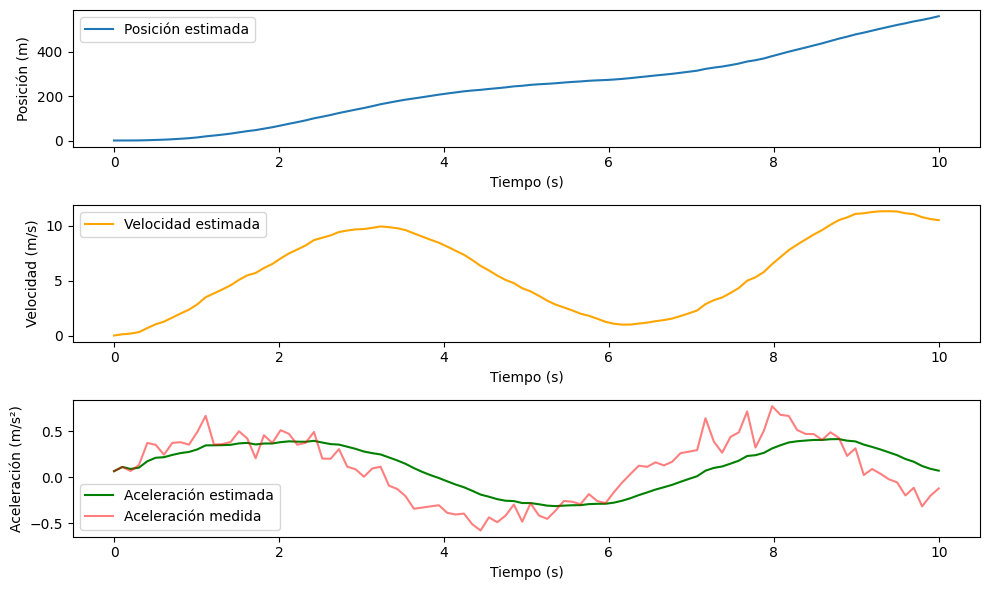

In [34]:

def kalman_filter(z, Q, R):
    n = len(z)
    
    # Inicialización de matrices
    x_est = np.zeros((3, n))  # Estimaciones de [posición, velocidad, aceleración]
    P = np.eye(3)  # Matriz de covarianza de la estimación
    A = np.array([[1, 1, 0.5],  # Matriz de transición de estados
                  [0, 1, 1],
                  [0, 0, 1]])
    H = np.array([[0, 0, 1]])  # Matriz de observación (solo medimos aceleración)
    
    x_est[:, 0] = [0, 0, z[0]]  # Estado inicial (posición, velocidad, aceleración)
    I = np.eye(3)  # Matriz identidad
    
    # Procesos y mediciones
    for k in range(1, n):
        # Predicción
        x_pred = A @ x_est[:, k-1]
        P_pred = A @ P @ A.T + Q
        
        # Actualización
        y = z[k] - H @ x_pred  # Innovación o residual
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)  # Ganancia de Kalman
        
        x_est[:, k] = x_pred + K @ y
        P = (I - K @ H) @ P_pred
        
    return x_est

# Datos simulados del acelerómetro (ejemplo)
time = np.linspace(0, 10, 100)  # Tiempo
true_acc = 0.5 * np.sin(time)  # Aceleración simulada como seno
z = true_acc + 0.1 * np.random.randn(len(time))  # Medición con ruido

# Parámetros del filtro de Kalman
Q = np.array([[1e-5, 0, 0],  # Ruido del proceso
              [0, 1e-5, 0],
              [0, 0, 1e-4]])
R = np.array([[1e-2]])  # Ruido de la medición

# Aplicar el filtro de Kalman
estimations = kalman_filter(z, Q, R)

# Graficar resultados
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(time, estimations[0], label='Posición estimada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, estimations[1], label='Velocidad estimada', color='orange')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad (m/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, estimations[2], label='Aceleración estimada', color='green')
plt.plot(time, z, label='Aceleración medida', color='red', alpha=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración (m/s²)')
plt.legend()

plt.tight_layout()
plt.show()

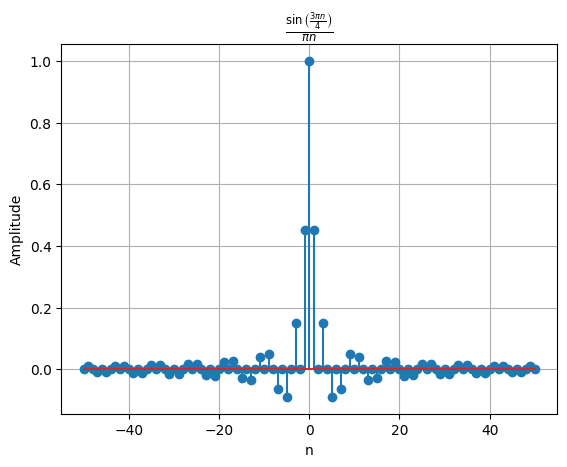

In [7]:
n = np.arange(-50, 51, 1)
n[n == 0] = 1e-10  # Reemplazamos n=0 con un valor muy pequeño para evitar la división por 0

signal = np.zeros_like(n, dtype=float)  # Inicializar la señal
signal[n != 0] = (np.sin((3 * np.pi * n[n != 0]) / 4)) / (np.pi * n[n != 0])  # Para n != 0
signal[n == 0] = 3 / 4  # Para n = 0

# Signal 2
signal2 = np.zeros_like(n, dtype=float)  # Inicializar la señal
signal2[n != 0] = (np.sin((np.pi * n[n != 0]) / 4)) / (np.pi * n[n != 0])  # Para n != 0
signal2[n == 0] = 1 / 4  # Para n = 0

signal_sum = signal + signal2

# Graficar la señal
plt.stem(n, signal_sum)
plt.title(r'$\frac{\sin\left(\frac{3\pi n}{4}\right)}{\pi n}$')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [12]:
n = np.arange(-50, 51, 1)

# Delta de Dirac: 1 en n=0, 0 en otros lugares
delta = np.zeros_like(n)
delta[n == 0] = 1

# Calcular el segundo término (1 + (-1)^n) * (sin((pi*n)/4) / (pi*n))
signal_part = np.zeros_like(n, dtype=float)
signal_part[n != 0] = (1 + np.power(-1, n[n != 0])) * (np.sin(np.pi * n[n != 0] / 4)) / (np.pi * n[n != 0])
signal_part[n == 0] = 0  # Evitamos la singularidad en n=0

# La señal x[n] = delta[n] - (1 + (-1)^n) * (sin((pi*n)/4) / (pi*n))
x_n = delta - signal_part

# Graficar la señal
plt.stem(n, x_n, use_line_collection=True)
plt.title(r'$x[n] = \delta[n] - \left(1 + (-1)^n\right) \cdot \frac{\sin\left(\frac{\pi n}{4}\right)}{\pi n}$')
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

ValueError: Integers to negative integer powers are not allowed.